In [1]:
# general imports
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
import wandb
import numpy as np

from torch.utils.data import DataLoader
from tqdm import tqdm
from upt.collators.ffs_collator import ffsCollator
from upt.datasets.ffs_dataset import ffsDataset

In [2]:
# check successful setup
print(torch.__version__)
device = torch.device("cuda")
print(torch.cuda.get_device_name(device))
import torchvision
print(torchvision.__version__)
from torch_geometric.nn.pool import radius_graph
from torch_scatter import segment_csr



2.5.1+cu124
NVIDIA GeForce GTX 970
0.20.1+cu124


# RANS FFS

In [3]:
# hyperparameters model
dim = 256
num_heads = 4
radius = 5
max_degree=32
depth=4
num_latent_tokens=512

# hyperparameters training
learning_rate = 1e-4
weight_decay=0.05
num_supernodes = 512
epochs = 1000
batch_size = 50

runID = 'SDF_600_samples_reFix'

Datasets

In [4]:
from upt.datasets.ffs_dataset import ffsDataset

num_test_inputs  = 4096
num_test_outputs = 4096
# num_train_inputs  = 8192
# num_train_outputs = 16000

num_train_inputs  = num_test_inputs 
num_train_outputs = num_test_outputs

crop_values= [[-3, -2], [3, 2]]

# initialize dataset
train_dataset = ffsDataset(
    root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=num_train_inputs,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=num_train_outputs,
    # mode
    mode="train",
    # crop
    crop_values= crop_values,
)

test_dataset = ffsDataset(
    root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=num_test_inputs,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=num_test_outputs,
    # mode
    mode="test",
    # crop
    crop_values= crop_values,
)


Dataloaders

In [5]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from upt.collators.ffs_collator import ffsCollator

# setup dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=ffsCollator(num_supernodes=num_supernodes, deterministic=False),
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    collate_fn=ffsCollator(num_supernodes=num_supernodes, deterministic=True),
)

Model

In [6]:
from upt.models.ffs_upt import ffsUPT
# from upt.models.upt import UPT
from upt.models.approximator import Approximator
from upt.models.decoder_perceiver import DecoderPerceiver
from upt.models.encoder_supernodes import EncoderSupernodes
from upt.models.conditioner_re import ConditionerRe

# initialize model
conditioner = ConditionerRe(
    dim=dim,
    num_values=train_dataset.num_values,
)
model = ffsUPT(
    conditioner=conditioner,
    encoder=EncoderSupernodes(
        # simulation has 1 input sdf
        input_dim=1,
        # 2D dataset
        ndim=2,
        # positions are rescaled to [0, 200]
        radius=radius,
        # in regions where there are a lot of mesh cells, it would result in supernodes having a lot of
        # connections to nodes. but since we sample the supernodes uniform, we also have a lot of supernodes
        # in dense regions, so we can simply limit the maximum amount of connections to each supernodes
        # to avoid an extreme amount of edges
        max_degree=max_degree,
        # dimension for the supernode pooling -> use same as ViT-T latent dim
        gnn_dim=dim,
        # ViT-T latent dimension
        enc_dim=dim,
        enc_num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        enc_depth=depth,
        # downsample to 128 latent tokens for fast training
        perc_dim=dim,
        perc_num_heads=num_heads,
        num_latent_tokens=num_latent_tokens,
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
    approximator=Approximator(
        # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
        input_dim=dim,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=depth,
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
    decoder=DecoderPerceiver(
        # tell the decoder the dimension of the input (dim of approximator)
        input_dim=dim,
        # 2D velocity + pressure
        output_dim=3,
        # simulation is 2D
        ndim=2,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=depth,
        # we assume num_outputs to be constant so we can simply reshape the dense result into a sparse tensor
        unbatch_mode="dense_to_sparse_unpadded",
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
)
model = model.to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

parameters: 34.9M


WandB Init

In [ ]:
# # Start a new wandb run to track this script.
# run = wandb.init(
#     # Set the wandb entity where your project will be logged (generally your team name).
#     entity="battlejacket-liu",
#     name=runID,
#     # Set the wandb project where this run will be logged.
#     project="UPT-DO",
#     # Track hyperparameters and run metadata.
#     config={
#         "learning_rate": learning_rate,
#         "dataset": "ffs",
#         "epochs": epochs,
#         "num_test_inputs": num_test_inputs,
#         "num_test_outputs": num_test_outputs,
#         "num_train_inputs": num_train_inputs,
#         "num_train_outputs": num_train_outputs,
#         "dim": dim,
#         "num_heads": num_heads,
#         "batch_size": batch_size,
#         "weight_decay": weight_decay,
#         "num_supernodes": num_supernodes,
#         "depth": depth,
#         "encoder_radius": radius,
#         "encoder_max_degree": max_degree,
#         "encoder_num_latent_tokens": num_latent_tokens,
#     },
# )

Train Model

In [ ]:
# # initialize optimizer and learning rate schedule (linear warmup for first 10% -> linear decay)
# optim = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# total_updates = len(train_dataloader) * epochs
# warmup_updates = int(total_updates * 0.1)
# lrs = torch.concat(
#     [
#         # linear warmup
#         torch.linspace(0, optim.defaults["lr"], warmup_updates),
#         # linear decay
#         torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
#     ],
# )

# # train model
# update = 0
# pbar = tqdm(total=total_updates)
# pbar.update(0)
# pbar.set_description("train_loss: ????? train_accuracy: ????% test_accuracy: ????%")
# test_accuracy = 0.0
# train_losses = []
# test_losses = []
# loss = None
# test_loss = None
# for _ in range(epochs):
#     # train for an epoch
#     for batch in train_dataloader:
#         # schedule learning rate
#         for param_group in optim.param_groups:
#             param_group["lr"] = lrs[update]

#         # forward pass
#         y_hat = model(
#             input_feat=batch["input_feat"].to(device),
#             # input_feat=None,
#             input_pos=batch["input_pos"].to(device),
#             supernode_idxs=batch["supernode_idxs"].to(device),
#             batch_idx=batch["batch_idx"].to(device),
#             output_pos=batch["output_pos"].to(device),
#             re=batch["re"].to(device),

#         )
#         y = batch["target_feat"].to(device)
#         assert y_hat.shape == y.shape
#         loss = F.mse_loss(y_hat, y)

#         # backward pass
#         loss.backward()

#         # update step
#         optim.step()
#         optim.zero_grad()

#         # status update
#         update += 1
#         pbar.update()
#         if test_loss is None:
#             pbar.set_description(f"train_loss: {loss.item():.4f}")
#         else:
#             pbar.set_description(
#                 f"train_loss: {loss.item():.4f} "
#                 f"test_loss: {test_loss:.4f} "
#             )
#         train_losses.append(loss.item())

#     # evaluate
#     test_loss = 0.
#     for batch in test_dataloader:
#         with torch.no_grad():
#             y_hat = model(
#                 input_feat=batch["input_feat"].to(device),
#                 # input_feat=None,
#                 input_pos=batch["input_pos"].to(device),
#                 supernode_idxs=batch["supernode_idxs"].to(device),
#                 batch_idx=batch["batch_idx"].to(device),
#                 output_pos=batch["output_pos"].to(device),
#                 re=batch["re"].to(device),
#             )
#         y = batch["target_feat"].to(device)
#         test_loss += (F.mse_loss(y_hat, y, reduction="sum") / y.numel()).item()
#     test_loss /= len(test_dataloader)
#     test_losses.append(test_loss)
#     pbar.set_description(
#         f"train_loss: {loss.item():.4f} "
#         f"test_loss: {test_loss:.4f} "
#     )
#     wandb.log(
#         {
#             "train_loss": loss.item(),
#             "test_loss": test_loss,
#             "learning_rate": optim.param_groups[0]["lr"],
#         }
#     )
# pbar.close()

Save & Load Model

In [9]:
# path = 'save/' + runID + '.pth'
# torch.save(model.state_dict(), path)
# # wandb.save('save/sdf_model.pth')

In [7]:
path = 'save/' + runID + '.pth'
model.load_state_dict(torch.load(path, weights_only=True))
model.eval()

ffsUPT(
  (conditioner): ConditionerRe(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
    )
    (re_embed): ContinuousSincosEmbed(dim=256)
  )
  (encoder): EncoderSupernodes(
    (supernode_pooling): SupernodePooling(
      (input_proj): LinearProjection(
        (proj): Linear(in_features=1, out_features=256, bias=True)
      )
      (pos_embed): ContinuousSincosEmbed(dim=256)
      (message): Sequential(
        (0): LinearProjection(
          (proj): Linear(in_features=512, out_features=256, bias=True)
        )
        (1): GELU(approximate='none')
        (2): LinearProjection(
          (proj): Linear(in_features=256, out_features=256, bias=True)
        )
      )
    )
    (enc_proj): LinearProjection(
      (proj): Identity()
    )
    (blocks): Sequential(
      (0): DitBlock(
        (modulation): Dit(
          (modulation): Linear(in_features=1024, out_features=1536, bias=True)
        )
        (norm1): LayerNorm

Test and Inference

In [13]:
test_hr_dataset = ffsDataset(
    root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    num_inputs=float("inf"),
    # num_inputs=40000,
    # how many outputs to use for training
    num_outputs=float("inf"),
    # num_outputs=40000,
    # mode
    mode="test",
    crop_values=crop_values,
)
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

# get test sample
test_dataloader = DataLoader(
    dataset=test_hr_dataset,
    batch_size=1,
    collate_fn=ffsCollator(num_supernodes=512, deterministic=True),
)
data = [d for d in test_dataloader]

In [ ]:
F.l

In [ ]:

train_losses = []
test_losses = []
loss = None
test_loss = None
# # evaluate
test_loss = 0.
for batch in test_dataloader:
    with torch.no_grad():
        y_hat = model(
            input_feat=batch["input_feat"].to(device),
            # input_feat=None,
            input_pos=batch["input_pos"].to(device),
            supernode_idxs=batch["supernode_idxs"].to(device),
            batch_idx=batch["batch_idx"].to(device),
            output_pos=batch["output_pos"].to(device),
            re=batch["re"].to(device),
        )
    y = batch["target_feat"].to(device)
    test_loss = (F.mse_loss(y_hat, y, reduction="sum") / y.numel()).item()
    test_losses.append(test_loss)
    print(f"test_loss: {test_loss:.4f} ")


In [15]:
test_losses

[0.030167769640684128,
 0.008652817457914352,
 0.006143227685242891,
 0.017262021079659462,
 0.008692311123013496,
 0.00927624013274908,
 0.0016496279276907444,
 0.008034874685108662,
 0.0027461096178740263,
 0.015178980305790901,
 0.016540370881557465,
 0.012134629301726818,
 0.050515975803136826,
 0.0024809455499053,
 0.013275375589728355,
 0.019277889281511307,
 0.002339532831683755,
 0.00500012980774045,
 0.003069269238039851,
 0.11475248634815216,
 0.004624928813427687,
 0.0070009296759963036,
 0.00552584370598197,
 0.15751269459724426,
 0.005325509700924158,
 0.0028731210622936487,
 0.001463851542212069,
 0.021570825949311256,
 0.012986945919692516,
 0.04619162902235985,
 0.004811443388462067,
 0.01430774386972189,
 0.0037046559154987335,
 0.038301028311252594,
 0.010270142927765846,
 0.0059601240791380405,
 0.007467388175427914,
 0.011499088257551193,
 0.011541957966983318,
 0.00352835888043046,
 0.004020678345113993,
 0.01221397239714861,
 0.002407145919278264,
 0.0027779582887

In [7]:
test_batch = data[0]
name = test_batch['name'][0]
paramDef = {'name': str, 're': float, 'Lo': float, 'Ho': float}
from data.ffs.readParameters import readParametersFromFileName
parameters = readParametersFromFileName(name, paramDef)
re = parameters['re']
Lo = parameters['Lo']
Ho = parameters['Ho']

from ffsInference import ffsInference

inferencer = ffsInference(
    train_dataset=test_hr_dataset,
    totalPoints=10000,
    numSupernodes=512,
    model=model,
    device=device,
    useMesh='modify'
)



NameError: name 'model' is not defined

In [13]:

parameter_sets = np.array([(re, Lo, Ho)])  # Example parameter sets
# results = inferencer.infer(parameter_sets, output_pos=test_batch["output_pos"].clone())
results = inferencer.infer(parameter_sets)

Loading mesh took 0.0026 seconds.
Numpy conv. took 0.0009 seconds.
base mesh set


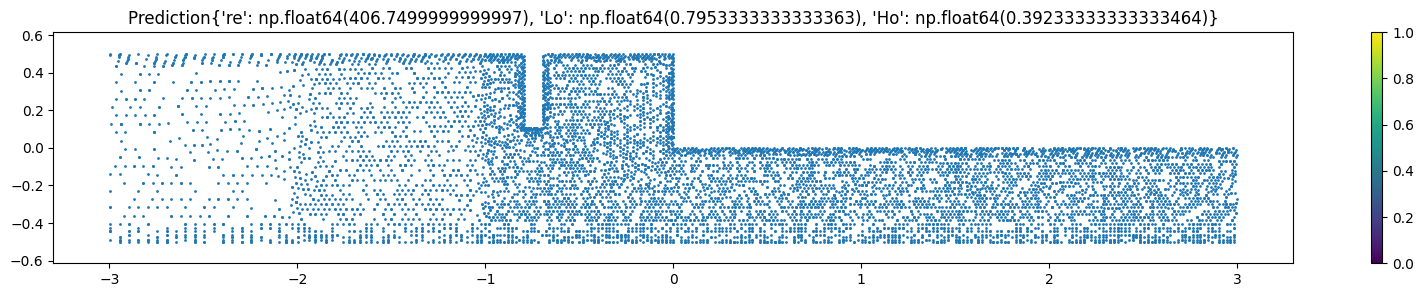

In [14]:
# generated input vs target
idx = 0
parameters = results['parameters'][idx]
parameterString = [(key + ': ' + str(value)) for key, value in parameters.items()]
points = results['points'][idx]
pred_all = results['predictions'][idx]


x_pos, y_pos = points.unbind(1)
pred = pred_all[:,0]
target_all = test_dataset.denormalize_feat(test_batch["target_feat"])[:10000]
target = target_all[:,0]

# Visualize
plt.figure(figsize=(20, 3))
plt.scatter(x_pos, y_pos, marker="o", s=1)
plt.colorbar()
plt.axis("equal")
plt.title("Prediction" + str(parameters))
plt.show()

# _, axes = plt.subplots(3, 1, figsize=(10, 5)) #, figsize=(10, 2)
# axes[0].scatter(x_pos, y_pos, c=target, marker="s", s=1)
# axes[0].set_title("target")
# axes[0].set_axis_off()
# axes[1].scatter(x_pos, y_pos, c=pred, marker="s", s=1)
# axes[1].set_title("generated")
# axes[1].set_axis_off()
# scatter_diff = axes[2].scatter(x_pos, y_pos, c=pred-target, marker="s", s=1)
# axes[2].set_title("diff")
# axes[2].set_axis_off()
# plt.colorbar(scatter_diff, ax=axes[2], orientation="horizontal")
# plt.tight_layout()
# # plt.colorbar()
# # plt.title(test_batch["name"])
# plt.show()

In [15]:
# make predictions

with torch.no_grad():
    y_hat = model(
        input_feat=test_batch["input_feat"].to(device),
        input_pos=test_batch["input_pos"].to(device),
        # input_pos=test_hr_dataset.denormalize_pos(points).to(device),
        supernode_idxs=test_batch["supernode_idxs"].to(device),
        batch_idx=test_batch["batch_idx"].to(device),
        output_pos=test_batch["output_pos"].to(device),
        re=test_batch["re"].to(device),
    )

In [19]:
import numpy as np
import time
import os
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination.default import DefaultMultiObjectiveTermination
from optimization import ffsOptProblem

param_ranges = {
    'Re': (100, 1000),
    'Lo': (0.2, 1),
    'Ho': (0.1, 0.5),
    }



xl=np.array([float(param_ranges['Lo'][0]),float(param_ranges['Ho'][0])])
xu=np.array([float(param_ranges['Lo'][1]),float(param_ranges['Ho'][1])])

# inferencer = ffsInference(
#     train_dataset=test_hr_dataset,
#     totalPoints=40000,
#     numSupernodes=512,
    
# )

optResultsPath = "./optimizationResults/"

optPath = optResultsPath

reRange = [300]

print('defining problem')

# problem = ffsOptProblem(n_var=2,n_obj=1, xl=xl, xu=xu, inferencer=inferencer, maxDesignsPerEvaluation=500)


for re in reRange:

    if os.path.exists(optPath + "/optResultsX" + str(re) + ".npy"):
        print("skipping ", optPath + " " + str(re))
        continue
    
    optStartTime = time.time()
    
    # print("Optimizing: ", str(model) + " " + str(re))
    print("Optimizing: " + str(re))
    
    # problem.re = re 
    problem = ffsOptProblem(n_var=2,n_obj=1, xl=xl, xu=xu,
                inferencer=inferencer, re=re, maxDesignsPerEvaluation=500)
    algorithm = DE(pop_size=200)

    termination = DefaultMultiObjectiveTermination(
        n_max_gen=1000, # default 1000
        n_max_evals=10000000
    )

    results = minimize(problem=problem, algorithm=algorithm,termination=termination)

    # with open("checkpoint", "wb") as f:
    #     dill.dump(algorithm, f)


    print("Optimization Done in ", time.time() - optStartTime)
    print("Best Design Objective Value: ", results.F)
    print("Best Design Parameter Value: ", results.X)

defining problem
Optimizing: 300
Evaluation time:  181.01319122314453
Evaluation time:  181.61883878707886
Evaluation time:  180.83258509635925
Evaluation time:  181.21563863754272
Evaluation time:  181.46193552017212
Evaluation time:  180.94024109840393
Evaluation time:  182.0038275718689
Evaluation time:  182.05074214935303
Evaluation time:  181.3453392982483
Evaluation time:  182.15138459205627
Evaluation time:  182.1151406764984
Evaluation time:  181.3843822479248
Evaluation time:  181.76652002334595
Evaluation time:  182.2478551864624
Evaluation time:  181.90203332901
Evaluation time:  182.640686750412
Evaluation time:  182.39379143714905
Evaluation time:  182.96542477607727
Evaluation time:  183.02600049972534
Evaluation time:  182.3709592819214
Evaluation time:  184.01451969146729
Evaluation time:  183.29308438301086
Evaluation time:  183.15306425094604
Evaluation time:  183.22989439964294
Evaluation time:  182.71338891983032
Evaluation time:  182.81706857681274
Evaluation time:

In [19]:
results.pop.get("X")

array([[0.38557772, 0.12830548],
       [0.22727655, 0.31795327],
       [0.35737369, 0.10256339],
       [0.22232151, 0.4567092 ],
       [0.23015443, 0.25337661],
       [0.23760662, 0.31155797],
       [0.23683486, 0.40475622],
       [0.36516959, 0.30191137],
       [0.21617472, 0.23115033],
       [0.22152079, 0.1639424 ]])

In [20]:
results.pop.get("F")

array([[10.92974758],
       [10.92199898],
       [10.93304157],
       [11.24220943],
       [10.97537327],
       [10.94311237],
       [10.86431789],
       [10.94545174],
       [10.9359293 ],
       [10.94583607]])

In [21]:
# Create points to use for inference, one line upsteam and one line downstream of the step
upstreamX = -3
downstreamX = 3
numPoints = 5
upstreamPoints = torch.tensor([[upstreamX, y] for y in np.linspace(-0.5, 0.5, numPoints)], dtype=torch.float32)
downstreamPoints = torch.tensor([[downstreamX, y] for y in np.linspace(-0.5, 0.5, numPoints)], dtype=torch.float32)
points = torch.cat((upstreamPoints, downstreamPoints), dim=0).unsqueeze(0)

points = inferencer.train_dataset.normalize_pos(points)

# fluidParameters
rho = 1.0
Um = 1.0
re = 300.0

# for designs in np.array_split(ary=allDesigns, indices_or_sections=batches):
designs = results.pop.get("X")
    # Inference
    # Create a column of c values with the same number of rows as a
re_column = np.full((designs.shape[0], 1), re)

# Concatenate along the second axis (columns)
parameter_sets = np.concatenate((re_column, designs), axis=1)


results = inferencer.infer(parameter_sets=parameter_sets, output_pos=points)
prediction = results['predictions']
upstreamPressures = prediction[:, :, 2][:,:numPoints]
downstreamPressures = prediction[:, :, 2][:,numPoints:]

upstreamPressure = upstreamPressures.mean(dim=1)
downstreamPressure = downstreamPressures.mean(dim=1)

dCp =  2*(upstreamPressure-downstreamPressure)/(rho*Um**2)
print("dCp: ", dCp)
# valuesF.append(dCp.detach().cpu().numpy())

out = dCp.detach().cpu().numpy() #np.array(valuesF)
print(out)

dCp:  tensor([10.9297, 10.9220, 10.9330, 11.2422, 10.9754, 10.9431, 10.8643, 10.9455,
        10.9359, 10.9458])
[10.929748 10.921999 10.933042 11.242209 10.975373 10.943112 10.864318
 10.945452 10.935929 10.945836]
